<a href="https://colab.research.google.com/github/TakshDhabalia/Research-and-MusicGeneration/blob/CNN_audio_Cat/Audio_Cat_input_params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy matplotlib tensorflow scikit-learn


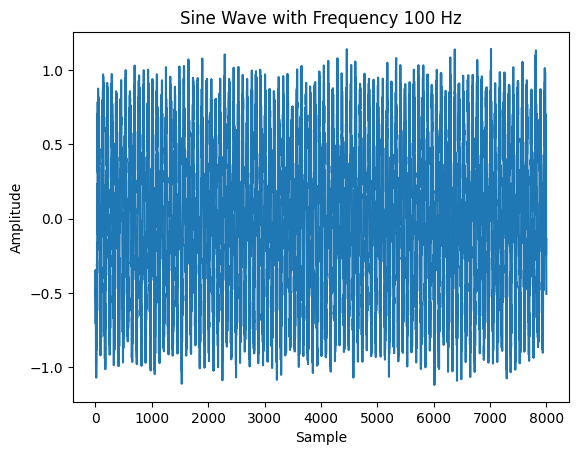

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split, KFold

# Function to generate sinusoidal waves with noise
def generate_sine_wave_with_noise(freq, sample_rate, duration, amplitude=1.0, phase=0.0, noise_level=0.1):
    x = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    frequencies = x * freq
    y = amplitude * np.sin((2 * np.pi) * frequencies + phase)
    noise = np.random.normal(0, noise_level, y.shape)
    return x, y + noise

# Parameters
sample_rate = 8000  # 8 kHz sample rate
duration = 1.0  # 1 second
frequencies = [100, 200, 300, 400, 500]  # Frequencies in Hz
num_examples_per_freq = 50  # Number of examples per frequency

# Generate dataset with noise
dataset = []
labels = []
for freq in frequencies:
    for _ in range(num_examples_per_freq):
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        phase = np.random.uniform(0, 2*np.pi)  # Random phase
        _, wave = generate_sine_wave_with_noise(freq, sample_rate, duration, amplitude, phase, noise_level=0.1)
        dataset.append(wave)
        labels.append(freq)

# Convert to numpy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Normalize the dataset
dataset = (dataset - np.mean(dataset)) / np.std(dataset)

# Create a mapping from frequencies to integer labels
label_map = {freq: i for i, freq in enumerate(frequencies)}
integer_labels = np.array([label_map[freq] for freq in labels])

# Plot an example
plt.plot(dataset[0])
plt.title(f"Sine Wave with Frequency {labels[0]} Hz")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# Reshape dataset for the CNN to have 1024 input channels
num_input_channels = 1024
dataset = dataset[:, :num_input_channels].reshape(-1, num_input_channels, 1)


In [ ]:
# Parameters for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Cross-validation loop
fold = 1
accuracies = []

for train_index, test_index in kf.split(dataset):
    X_train, X_test = dataset[train_index], dataset[test_index]
    y_train, y_test = integer_labels[train_index], integer_labels[test_index]

    # Define the model
    model = Sequential([
        Conv1D(512, 8, activation='relu', input_shape=(num_input_channels, 1)),
        MaxPooling1D(4),
        Dropout(0.25),
        Conv1D(512, 8, activation='relu'),
        MaxPooling1D(4),
        Dropout(0.25),
        Conv1D(512, 8, activation='relu'),
        Flatten(),
        Dense(360, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
    print(f"Fold {fold}, Test Accuracy: {accuracy * 100:.2f}%")
    fold += 1

# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Test Accuracy: {average_accuracy * 100:.2f}%")


Fold 1, Test Accuracy: 100.00%
Fold 2, Test Accuracy: 100.00%
Fold 3, Test Accuracy: 100.00%
Fold 4, Test Accuracy: 100.00%
Fold 5, Test Accuracy: 100.00%
Average Test Accuracy: 100.00%


1/1 [==============================] - 0s 81ms/step


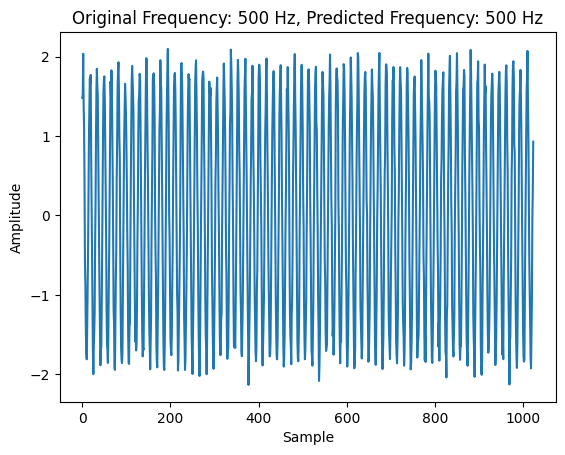

In [7]:
import random

# Get a random sample from the test set
index = random.randint(0, len(X_test) - 1)
sample = X_test[index]

# Predict the label
prediction = model.predict(sample.reshape(1, num_input_channels, 1))
predicted_label = np.argmax(prediction)

# Original label
original_label = y_test[index]

# Map integer label back to frequency
original_frequency = frequencies[original_label]
predicted_frequency = frequencies[predicted_label]

# Plot the waveform
plt.plot(sample)
plt.title(f"Original Frequency: {original_frequency} Hz, Predicted Frequency: {predicted_frequency} Hz")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()
